# Import dataset

In [1]:
import tensorflow as tf
import keras 
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing

from sklearn.model_selection import train_test_split,GridSearchCV
import cv2 as cv
import time

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import load_model
from tensorflow.keras.models import Model


from tensorflow import keras
import tarfile
from shutil import copyfile

Collegamento a Google Drive il caricamento dei dati

https://www.kaggle.com/jehanbhathena/weather-dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
copyfile('gdrive/My Drive/dataset.tar','dataset.tar')

tar= tarfile.open('dataset.tar')
tar.extractall()
tar.close()

In [4]:
def load_foto():
    maximages = 600
    labels = []
    foto = []
    dir='/content/dataset/'
    for f in sorted(os.listdir(dir)):
      for k, im in enumerate(sorted(os.listdir(dir + f))):
        if f !='rainbow' and im.endswith('.jpg') and im not in [ "4514.jpg" , "1187.jpg"] and k <maximages: 
          img = cv.imread( dir + f + '/' + im)
          img = cv.resize(img, (224,224), interpolation = cv.INTER_AREA)

          foto.append(img)
          label = f
          labels.append(label)
        
    X_train, X_test, y_train, y_test = train_test_split(foto, labels, test_size=0.2, random_state=1)

    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test=load_foto()

# Data Exploration

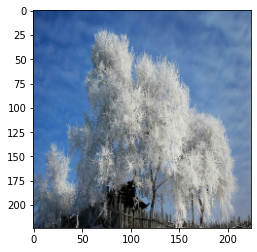

In [ ]:
plt.imshow(X_train[0][:,:,-1::-1])

In [ ]:
elements_count = {}
for element in y_train:
   if element in elements_count:
      elements_count[element] += 1
   else:
      elements_count[element] = 1
for key, value in elements_count.items():
   print(f"{key}: {value}")

rime: 491
fogsmog: 488
rain: 419
frost: 381
glaze: 466
lightning: 304
dew: 469
snow: 479
hail: 477
sandstorm: 479


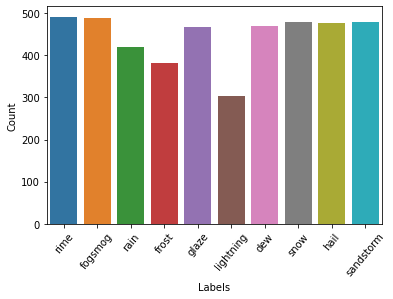

In [ ]:
sns.barplot(x=list(elements_count.keys()), y=list(elements_count.values()))
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

In [ ]:
elements_count = {}
for element in y_test:
   if element in elements_count:
      elements_count[element] += 1
   else:
      elements_count[element] = 1
for key, value in elements_count.items():
   print(f"{key}: {value}")

dew: 131
fogsmog: 111
snow: 120
hail: 114
rain: 107
lightning: 73
rime: 109
sandstorm: 121
frost: 94
glaze: 134


In [ ]:
path = '/content/dataset'
path_imgs = list(glob.glob(path+'/**/*.jpg'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/dataset/rainbow/0653.jpg,rainbow
1,/content/dataset/rime/5493.jpg,rime
2,/content/dataset/frost/4070.jpg,frost
3,/content/dataset/fogsmog/4194.jpg,fogsmog
4,/content/dataset/rain/1570.jpg,rain


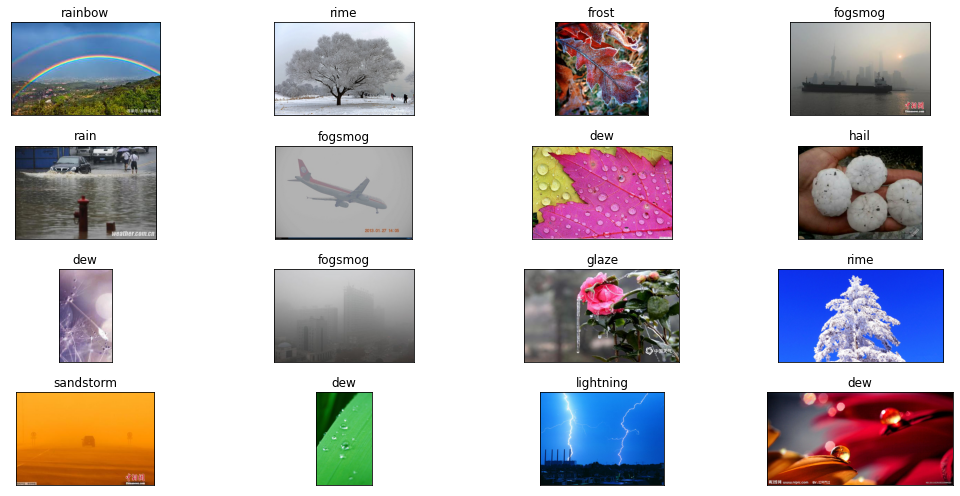

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

# Preprocessing

In [8]:
# preprocessing sui dati

X_train_nuovo = np.array(X_train)
X_test_nuovo =np.array(X_test)


#rendo le labels categoriche
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_train_nuovo = np_utils.to_categorical(y_train_enc, 10)
y_test_enc = encoder.fit_transform(y_test)
y_test_nuovo = np_utils.to_categorical(y_test_enc, 10)

#rinomino
#X_train=X_train_nuovo
#X_test= X_test_nuovo
#y_train=y_train_nuovo
#y_test=y_test_nuovo

# Il modello

Osservo il modello MobileNetV2

In [9]:
model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True, input_shape=(224,224,3))
model.summary()

14548992/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [10]:
model =tf.keras.applications.MobileNetV2(weights='imagenet', include_top=True, input_shape=(224,224,3))
model=keras.Model(inputs=model.input,
            outputs= model.get_layer('block_15_project_BN').output) 
 
  #model.summary()
for layer in model.layers:
    layer.trainable = False  


Layer aggiunti alla rete

In [11]:
from keras.models import Sequential
from tensorflow.keras import regularizers

prova = Sequential()
prova.add(keras.Input(shape=(224,224,3)))

prova.add(keras.layers.RandomFlip("horizontal"))
prova.add(keras.layers.RandomRotation(0.3, fill_mode="nearest"))
prova.add(keras.layers.RandomZoom(0.5))
prova.add(keras.layers.RandomContrast(0.5))
prova.add(keras.layers.RandomTranslation(height_factor=(-0.2, 0.2),width_factor=(-0.2, 0.2)))

#preprocessing
prova.add(keras.layers.Rescaling(scale=1./127.5, offset=-1))

prova.add(model)

prova.add(keras.layers.MaxPooling2D((2, 2)))
prova.add(keras.layers.Conv2D(320, (3, 3), padding = "same", activation='relu'))


prova.add(keras.layers.Flatten())
prova.add(keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
prova.add(keras.layers.Dropout(0.4))

prova.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
prova.add(keras.layers.Dropout(0.4))
prova.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
prova.add(keras.layers.Dropout(0.4))

prova.add(keras.layers.Dense(10, activation='softmax'))
prova.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                        

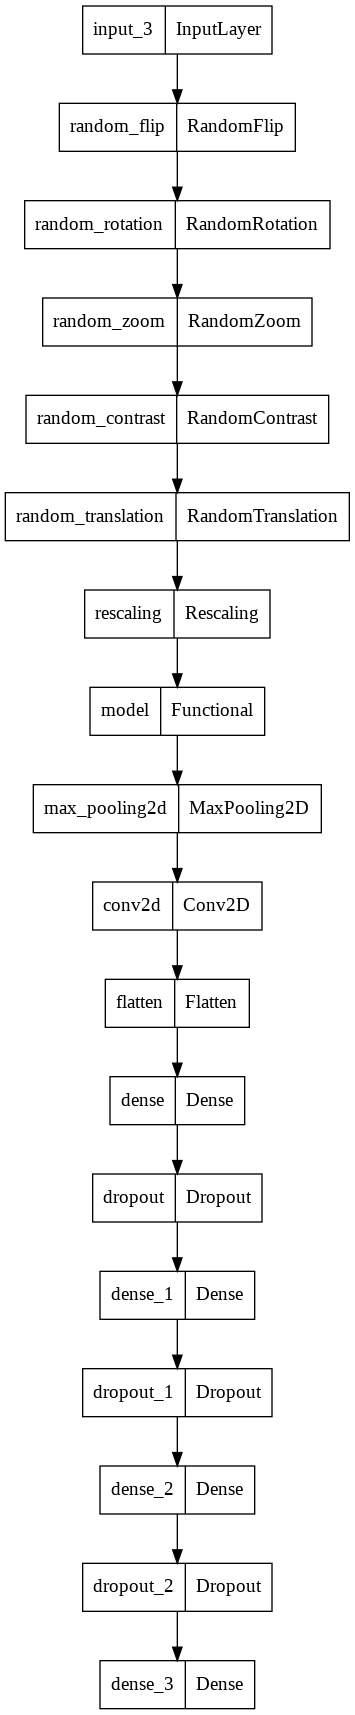

In [12]:
keras.utils.plot_model(prova)

## Training del modello

In [ ]:
prova.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])
# Model training
network_history = prova.fit(X_train_nuovo, y_train_nuovo,
          epochs=50, batch_size=64,
          validation_split = 0.2
        );


Epoch 1/50
56/56 [==============================] - 20s 122ms/step - loss: 15.3245 - accuracy: 0.1544 - val_loss: 7.8936 - val_accuracy: 0.2918
Epoch 2/50
56/56 [==============================] - 5s 97ms/step - loss: 5.6309 - accuracy: 0.3195 - val_loss: 3.7167 - val_accuracy: 0.5140
Epoch 3/50
56/56 [==============================] - 6s 100ms/step - loss: 3.1711 - accuracy: 0.4716 - val_loss: 2.3739 - val_accuracy: 0.5668
Epoch 4/50
56/56 [==============================] - 6s 102ms/step - loss: 2.2818 - accuracy: 0.5081 - val_loss: 1.8619 - val_accuracy: 0.5802
Epoch 5/50
56/56 [==============================] - 5s 98ms/step - loss: 1.8880 - accuracy: 0.5379 - val_loss: 1.6671 - val_accuracy: 0.5365
Epoch 6/50
56/56 [==============================] - 5s 92ms/step - loss: 1.6458 - accuracy: 0.5494 - val_loss: 1.4281 - val_accuracy: 0.5926
Epoch 7/50
56/56 [==============================] - 5s 92ms/step - loss: 1.5118 - accuracy: 0.5702 - val_loss: 1.2671 - val_accuracy: 0.6341
Epoch 8/

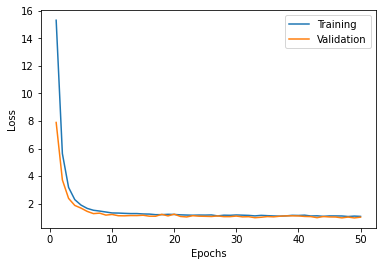

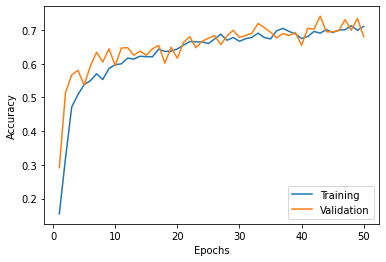

In [ ]:
from matplotlib import pyplot as plt
x_plot = list(range(1,50+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss']) 
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(network_history)

## Validazione del modello

In [ ]:
#accuracy sui dati di test
score1 = prova.evaluate(X_test_nuovo, y_test_nuovo)
score1

35/35 [==============================] - 2s 46ms/step - loss: 0.9691 - accuracy: 0.7092


[0.9691478610038757, 0.7091562151908875]

In [ ]:
prova.save('model_nuovo_taglio.h5') 

In [ ]:
#tempo di inferenza
t0 = time.time()
y_pred = prova.predict(X_test_nuovo)
t = time.time()-t0
print(t)

2.0182113647460938


In [ ]:
y = encoder.inverse_transform(np.argmax(y_test_nuovo, axis=1))
y_pred =encoder.inverse_transform(np.argmax(y_pred, axis=1))

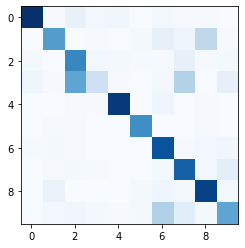

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y, y_pred)   
plt.imshow(cm, cmap=plt.cm.Blues)

In [ ]:
cm

array([[110,   1,   8,   3,   4,   0,   3,   1,   1,   0],
       [  0,  63,   0,   1,   0,   2,   9,   5,  30,   1],
       [  2,   0,  73,   3,   2,   1,   1,   9,   1,   2],
       [  5,   1,  59,  23,   1,   0,   2,  34,   0,   9],
       [  0,   0,   1,   1, 106,   0,   5,   0,   1,   0],
       [  0,   1,   1,   0,   0,  70,   0,   0,   1,   0],
       [  1,   2,   1,   0,   0,   0,  95,   1,   3,   4],
       [  0,   1,   2,   1,   0,   0,   2,  89,   3,  11],
       [  0,   7,   0,   0,   0,   2,   5,   2, 102,   3],
       [  0,   3,   4,   2,   1,   2,  35,  12,   2,  59]])

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

         dew       0.93      0.84      0.88       131
     fogsmog       0.80      0.57      0.66       111
       frost       0.49      0.78      0.60        94
       glaze       0.68      0.17      0.27       134
        hail       0.93      0.93      0.93       114
   lightning       0.91      0.96      0.93        73
        rain       0.61      0.89      0.72       107
        rime       0.58      0.82      0.68       109
   sandstorm       0.71      0.84      0.77       121
        snow       0.66      0.49      0.56       120

    accuracy                           0.71      1114
   macro avg       0.73      0.73      0.70      1114
weighted avg       0.73      0.71      0.69      1114

